<center>
    <img src="./Images/banner.webp" alt="Image description" style="width:90%;"/>
</center>

<h1 align='center'>Automated Wood Surface Defect Detection Using Computer Vision and Machine Learning</h1>

<h1 align='center'>Overview</h1>

This project focuses on automating wood surface defect detection using computer vision and machine learning techniques. By leveraging bounding box annotations and image data, the goal is to classify and localize defects to improve quality control processes in the wood industry.

### BLUF
- **Data Insights:** The dataset includes 4000 images and corresponding bounding box annotations, reduced to 100 for demonstration purposes. Bounding box counts and image dimensions were analyzed for variability.
- **Model Performance:** Three models were evaluated:
    - **Random Forest:** Best overall performance with an F1-score of 0.49.
    - **SVC:** Competitive but slightly lower F1-score of 0.48.
    - **Logistic Regression:** Least effective with an F1-score of 0.45.
- **Business Impact:** The Random Forest model shows potential for semi-automated defect detection but requires further improvement in precision and recall for underrepresented defect classes.



<h1 align='center'>Business Understanding</h1>

Woodworkers, sawmills, and lumber suppliers all rely on high-quality woods. However, surface defects such as cracks, knots, or decay can significantly degrade material quality and impact structural properties, and aesthetics. Currently, visual inspection is manual and time-consuming, with the potential for human error.

This project aims to automate wood surface defect detection using computer vision to improve consistency, speed, and accuracy of quality control before instrument construction begins.

### The next two cells are for shrinking the the dataset down into a more sharable size and to have a small test data set.
If you want to shrink the data down: 
1. put into a directory name 'Full_data'
2. Uncomment these cells and run them

In [104]:
# import os
# import shutil

# # Define source and destination directories
# source_images_dir = 'Full_Data/Images - 1'
# dest_images_dir = 'Data/Images'
# source_bboxes_dir = 'Full_Data/Bounding Boxes - YOLO Format - 1'
# dest_boxes_dir = 'Data/Bounding_Boxes'

# # Ensure destination directories exist
# os.makedirs(dest_images_dir, exist_ok=True)
# os.makedirs(dest_bboxes_dir, exist_ok=True)

# # Get a list of image files
# image_files = [f for f in os.listdir(source_images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# # Copy 100 images and their corresponding bounding box files
# for image_file in image_files[:100]:
#     # Copy image file
#     src_image_path = os.path.join(source_images_dir, image_file)
#     dest_image_path = os.path.join(dest_images_dir, image_file)
#     shutil.copy(src_image_path, dest_image_path)

#     # Copy corresponding bounding box file
#     bbox_file = os.path.splitext(image_file)[0] + '.txt'
#     src_bbox_path = os.path.join(source_bboxes_dir, bbox_file)
#     dest_bbox_path = os.path.join(dest_bboxes_dir, bbox_file)

#     if os.path.exists(src_bbox_path):
#         shutil.copy(src_bbox_path, dest_bbox_path)

# print("100 images and their bounding boxes have been copied.")

In [105]:
# import os
# import shutil

# # Define source and destination directories
# source_images_dir = 'Full_Data/Images - 1'
# source_bboxes_dir = 'Full_Data/Bounding Boxes - YOLO Format - 1'
# test_images_dir = 'Test_data/Images'
# test_bboxes_dir = 'Test_data/Bounding_Boxes'

# # Ensure destination directories exist
# os.makedirs(test_images_dir, exist_ok=True)
# os.makedirs(test_bboxes_dir, exist_ok=True)

# # Get a list of image files
# image_files = [f for f in os.listdir(source_images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# # Copy the last 20 images and their corresponding bounding box files
# for image_file in image_files[-20:]:
#     # Copy image file
#     src_image_path = os.path.join(source_images_dir, image_file)
#     dest_image_path = os.path.join(test_images_dir, image_file)
#     shutil.copy(src_image_path, dest_image_path)

#     # Copy corresponding bounding box file
#     bbox_file = os.path.splitext(image_file)[0] + '.txt'
#     src_bbox_path = os.path.join(source_bboxes_dir, bbox_file)
#     dest_bbox_path = os.path.join(test_bboxes_dir, bbox_file)

#     if os.path.exists(src_bbox_path):
#         shutil.copy(src_bbox_path, dest_bbox_path)

# print("Last 20 images and their bounding boxes have been copied to the test directories.")

In [119]:
# Imports
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from IPython.display import display

<h1 align='center'>Data Understanding</h1>
- The dataset includes images and corresponding bounding box annotations in YOLO

Image Data Summary:
         Width  Height
count   100.00   100.0
mean   2799.77  1024.0
std       2.30     0.0
min    2777.00  1024.0
25%    2800.00  1024.0
50%    2800.00  1024.0
75%    2800.00  1024.0
max    2800.00  1024.0


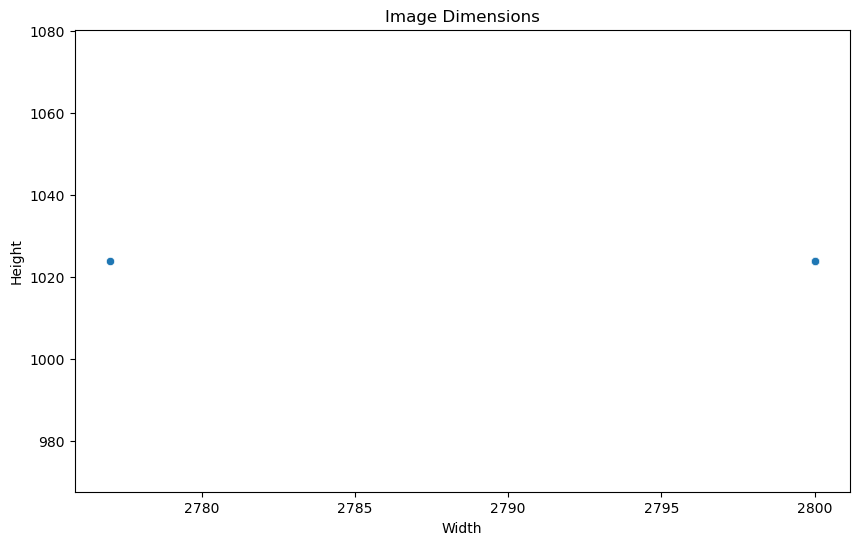

Bounding Box Data Summary:
       BoundingBoxCount
count         100.00000
mean            2.25000
std             1.37345
min             0.00000
25%             1.00000
50%             2.00000
75%             3.00000
max             7.00000


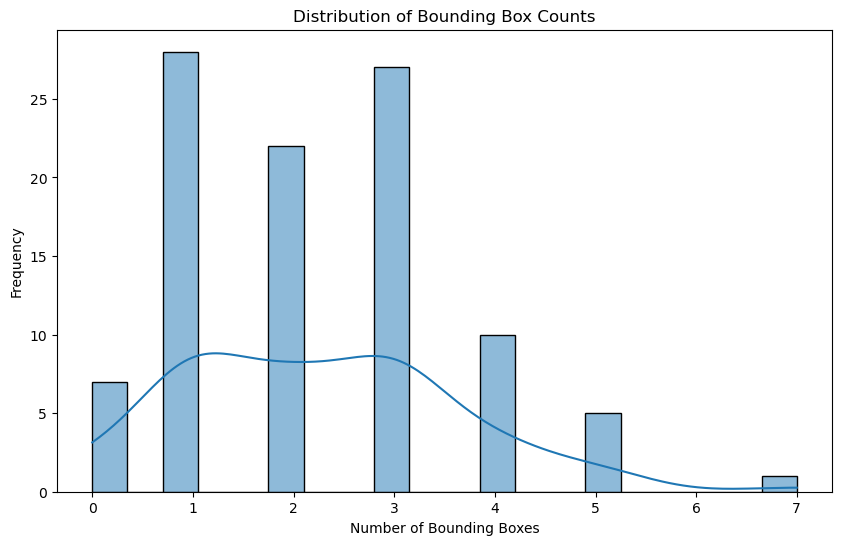

In [106]:
# Define directories
images_dir = 'Data/Images'
bboxes_dir = 'Data/Bounding_Boxes'

# Analyze image data
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
image_dimensions = []
for image_file in image_files:
    with Image.open(os.path.join(images_dir, image_file)) as img:
        image_dimensions.append(img.size)  # (width, height)

# Convert to DataFrame for analysis
image_df = pd.DataFrame(image_dimensions, columns=['Width', 'Height'])
print("Image Data Summary:")
print(image_df.describe())

# Plot image dimensions
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Width', y='Height', data=image_df)
plt.title('Image Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

# Analyze bounding box data
bbox_files = [f for f in os.listdir(bboxes_dir) if f.endswith('.txt')]
bbox_counts = []
for bbox_file in bbox_files:
    with open(os.path.join(bboxes_dir, bbox_file), 'r') as file:
        lines = file.readlines()
        bbox_counts.append(len(lines))

# Convert to DataFrame for analysis
bbox_df = pd.DataFrame({'File': bbox_files, 'BoundingBoxCount': bbox_counts})
print("Bounding Box Data Summary:")
print(bbox_df.describe())

# Plot bounding box counts
plt.figure(figsize=(10, 6))
sns.histplot(bbox_df['BoundingBoxCount'], bins=20, kde=True)
plt.title('Distribution of Bounding Box Counts')
plt.xlabel('Number of Bounding Boxes')
plt.ylabel('Frequency')
plt.show()

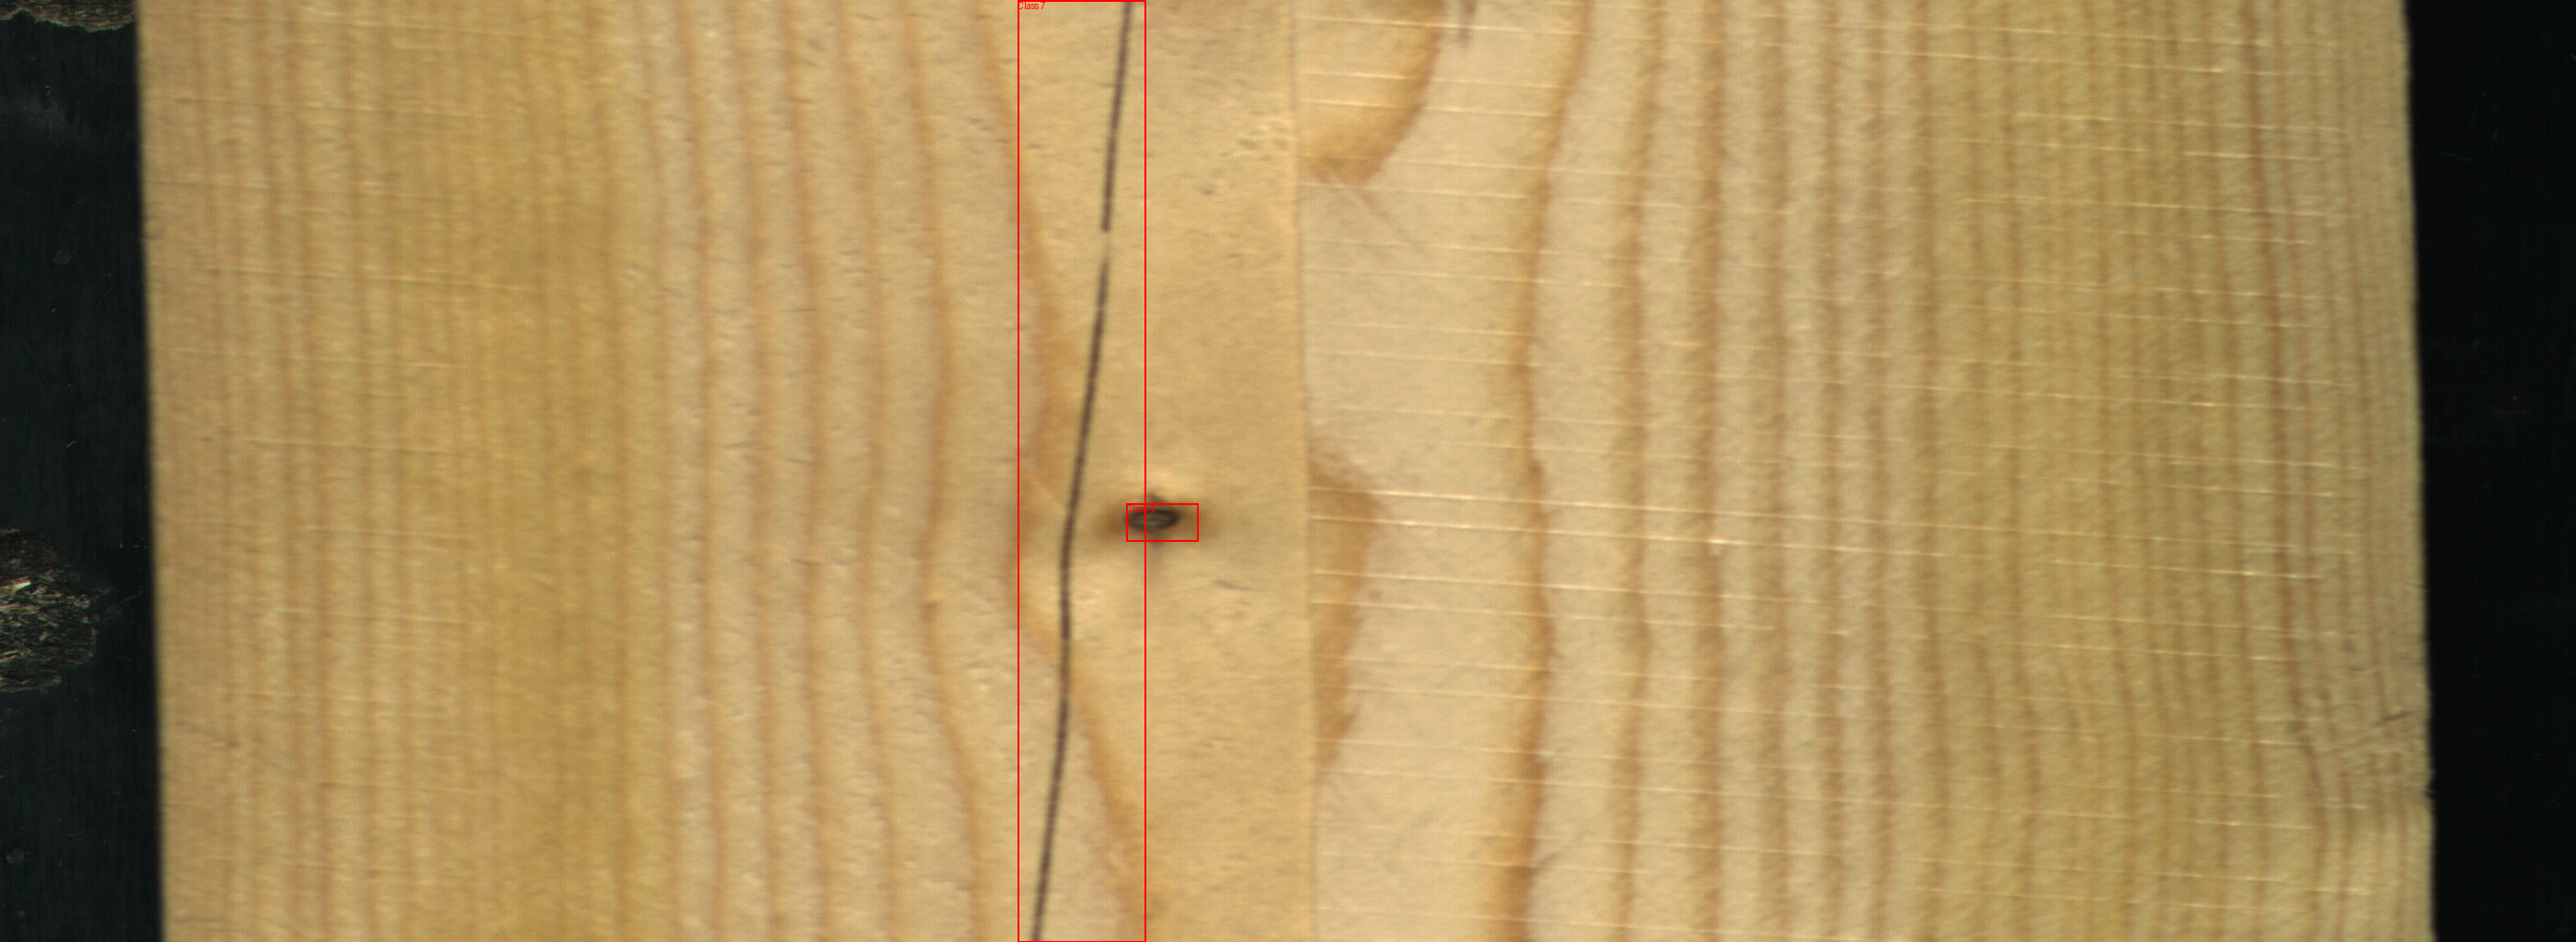

In [107]:
# Select an image and its corresponding bounding box file
image_file = '106100024.jpg'  # Example image file
bbox_file = os.path.splitext(image_file)[0] + '.txt'

# Load the image
image_path = os.path.join(images_dir, image_file)
with Image.open(image_path) as img:
    # Create a drawable image
    draw = ImageDraw.Draw(img)

    # Load the bounding box data
    bbox_path = os.path.join(bboxes_dir, bbox_file)
    if os.path.exists(bbox_path):
        with open(bbox_path, 'r') as file:
            for line in file:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                # Convert YOLO format to pixel coordinates
                img_width, img_height = img.size
                x_center *= img_width
                y_center *= img_height
                width *= img_width
                height *= img_height
                x_min = x_center - width / 2
                y_min = y_center - height / 2
                x_max = x_center + width / 2
                y_max = y_center + height / 2

                # Draw the bounding box
                draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
                draw.text((x_min, y_min), f"Class {int(class_id)}", fill="red")

    # Display the image
    display(img)

<h1 align='center'>Data Preparation</h1>

- The data preparation section involves resizing images to a uniform size of `(224, 224)` for consistency in model training.

- Corresponding bounding box annotations are adjusted to match the resized image dimensions.

- Processed images are saved in a new directory, and bounding box data is stored in a CSV file for further analysis.

- This ensures that the dataset is standardized and ready for model training and evaluation.

In [108]:
# Define directories
images_dir = 'Data/Images'
bboxes_dir = 'Data/Bounding_Boxes'
processed_images_dir = 'Data/Processed_Images'
processed_bboxes_file = 'Data/processed_bounding_boxes.csv'

# Ensure processed images directory exists
os.makedirs(processed_images_dir, exist_ok=True)

# Normalize image dimensions
target_size = (224, 224)  # Example size (width, height)
bounding_boxes = []

for image_file in os.listdir(images_dir):
    if image_file.endswith(('.jpg', '.png', '.jpeg')):
        # Open and resize image
        with Image.open(os.path.join(images_dir, image_file)) as img:
            img_resized = img.resize(target_size)
            img_resized.save(os.path.join(processed_images_dir, image_file))

        # Process corresponding bounding box file
        bbox_file = os.path.splitext(image_file)[0] + '.txt'
        bbox_path = os.path.join(bboxes_dir, bbox_file)
        if os.path.exists(bbox_path):
            with open(bbox_path, 'r') as file:
                for line in file:
                    class_id, x_center, y_center, width, height = map(float, line.strip().split())
                    # Adjust bounding box coordinates to the new image size
                    x_center *= target_size[0]
                    y_center *= target_size[1]
                    width *= target_size[0]
                    height *= target_size[1]
                    bounding_boxes.append({
                        'Image': image_file,
                        'ClassID': int(class_id),
                        'XCenter': x_center,
                        'YCenter': y_center,
                        'Width': width,
                        'Height': height
                    })

# Save bounding box data to a CSV file
bounding_boxes_df = pd.DataFrame(bounding_boxes)
bounding_boxes_df.to_csv(processed_bboxes_file, index=False)

print("Image data normalized and bounding box data prepared.")

Image data normalized and bounding box data prepared.


<h1 align='center'>Models</h1>

In [109]:
# Load processed bounding box data
data = pd.read_csv('Data/processed_bounding_boxes.csv')

# Example: Prepare features (X) and target (y)
X = data[['XCenter', 'YCenter', 'Width', 'Height']]
y = data['ClassID']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model 1: Random Forest

In [111]:
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=skf, scoring='f1_weighted', n_jobs=-1)
rf_grid.fit(X_train, y_train)
print("Random Forest Best Params:", rf_grid.best_params_)
rf_best = rf_grid.best_estimator_
rf_cv_scores = cross_val_score(rf_best, X_train, y_train, cv=skf, scoring='f1_weighted')
print("Random Forest CV F1-Score:", rf_cv_scores.mean())

/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Random Forest Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Random Forest CV F1-Score: 0.5585508216063773


/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


## Model 2

In [112]:
svc = SVC(random_state=42)
svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svc_grid = GridSearchCV(svc, svc_params, cv=5, scoring='accuracy')
svc_grid.fit(X_train, y_train)
print("SVC Best Params:", svc_grid.best_params_)
svc_best = svc_grid.best_estimator_
svc_cv_scores = cross_val_score(svc_best, X_train, y_train, cv=5)
print("SVC CV Accuracy:", svc_cv_scores.mean())

/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


SVC Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVC CV Accuracy: 0.6055555555555555


/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


## Model 3: Logistic Regression

In [113]:
lr = LogisticRegression(random_state=42, max_iter=1000)
lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}
lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='accuracy')
lr_grid.fit(X_train, y_train)
print("Logistic Regression Best Params:", lr_grid.best_params_)
lr_best = lr_grid.best_estimator_
lr_cv_scores = cross_val_score(lr_best, X_train, y_train, cv=5)
print("Logistic Regression CV Accuracy:", lr_cv_scores.mean())

/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Logistic Regression Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression CV Accuracy: 0.55


/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


## Evaluate models on test set


Classification Report:
              precision    recall  f1-score   support

     Class 1       0.59      0.65      0.62        20
     Class 2       0.00      0.00      0.00         2
     Class 3       0.75      1.00      0.86         3
     Class 4       0.43      0.40      0.41        15
     Class 5       0.00      0.00      0.00         2
     Class 7       0.25      0.33      0.29         3

    accuracy                           0.51        45
   macro avg       0.34      0.40      0.36        45
weighted avg       0.47      0.51      0.49        45

Confusion Matrix:
[[13  0  0  7  0  0]
 [ 0  0  0  0  0  2]
 [ 0  0  3  0  0  0]
 [ 8  0  0  6  1  0]
 [ 1  0  0  0  0  1]
 [ 0  0  1  1  0  1]]


/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

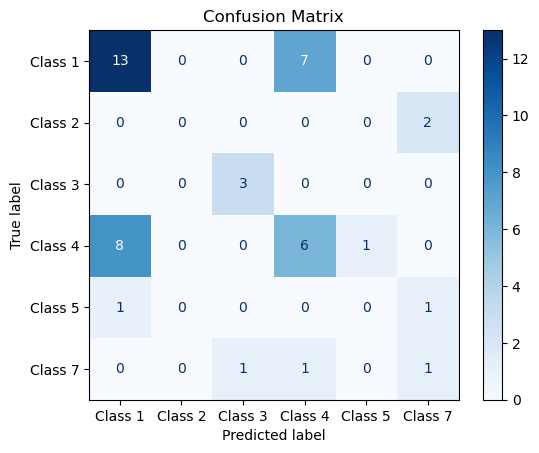

Classification Report:
              precision    recall  f1-score   support

     Class 1       0.59      0.65      0.62        20
     Class 2       1.00      0.50      0.67         2
     Class 3       0.60      1.00      0.75         3
     Class 4       0.47      0.47      0.47        15
     Class 5       0.00      0.00      0.00         2
     Class 7       0.00      0.00      0.00         3

    accuracy                           0.53        45
   macro avg       0.44      0.44      0.42        45
weighted avg       0.50      0.53      0.51        45

Confusion Matrix:
[[13  0  0  6  1  0]
 [ 0  1  0  0  0  1]
 [ 0  0  3  0  0  0]
 [ 8  0  0  7  0  0]
 [ 1  0  0  1  0  0]
 [ 0  0  2  1  0  0]]


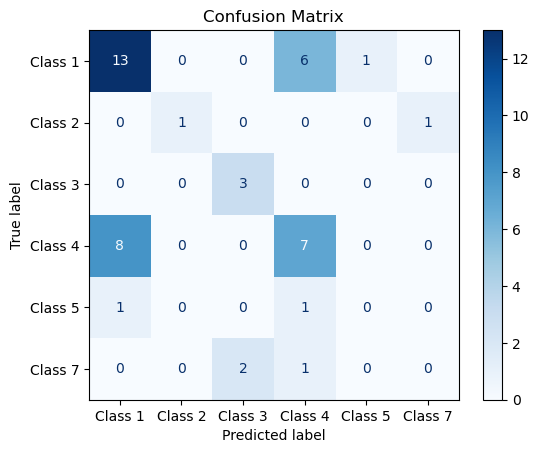

Classification Report:
              precision    recall  f1-score   support

     Class 1       0.56      0.45      0.50        20
     Class 2       0.00      0.00      0.00         2
     Class 3       0.33      0.33      0.33         3
     Class 4       0.41      0.60      0.49        15
     Class 5       0.00      0.00      0.00         2
     Class 7       0.00      0.00      0.00         3

    accuracy                           0.42        45
   macro avg       0.22      0.23      0.22        45
weighted avg       0.41      0.42      0.41        45

Confusion Matrix:
[[ 9  0  0 11  0  0]
 [ 0  0  0  0  0  2]
 [ 0  0  1  0  0  2]
 [ 6  0  0  9  0  0]
 [ 1  0  0  1  0  0]
 [ 0  0  2  1  0  0]]


/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

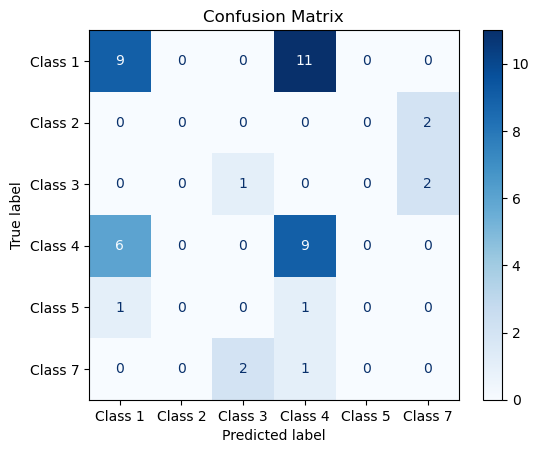

In [114]:
# Function to evaluate model performance on imbalanced datasets
def evaluate_model_performance(model, X_test, y_test, class_names):
    y_pred = model.predict(X_test)

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Visualize confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Example usage with Random Forest
class_names = [f"Class {i}" for i in sorted(y_test.unique())]
evaluate_model_performance(rf_best, X_test, y_test, class_names)

# Example usage with SVC
evaluate_model_performance(svc_best, X_test, y_test, class_names)

# Example usage with Logistic Regression
evaluate_model_performance(lr_best, X_test, y_test, class_names)

In [115]:
for model, name in zip([rf_best, svc_best, lr_best], ["Random Forest", "SVC", "Logistic Regression"]):
    y_pred = model.predict(X_test)
    print(f"{name} Test Accuracy:", accuracy_score(y_test, y_pred))
    print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))

Random Forest Test Accuracy: 0.5111111111111111
Random Forest Classification Report:
               precision    recall  f1-score   support

           1       0.59      0.65      0.62        20
           2       0.00      0.00      0.00         2
           3       0.75      1.00      0.86         3
           4       0.43      0.40      0.41        15
           5       0.00      0.00      0.00         2
           7       0.25      0.33      0.29         3

    accuracy                           0.51        45
   macro avg       0.34      0.40      0.36        45
weighted avg       0.47      0.51      0.49        45

SVC Test Accuracy: 0.5333333333333333
SVC Classification Report:
               precision    recall  f1-score   support

           1       0.59      0.65      0.62        20
           2       1.00      0.50      0.67         2
           3       0.60      1.00      0.75         3
           4       0.47      0.47      0.47        15
           5       0.00      0.00 

/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Random Forest Precision: 0.47
Random Forest Recall: 0.51
Random Forest F1-Score: 0.49


/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


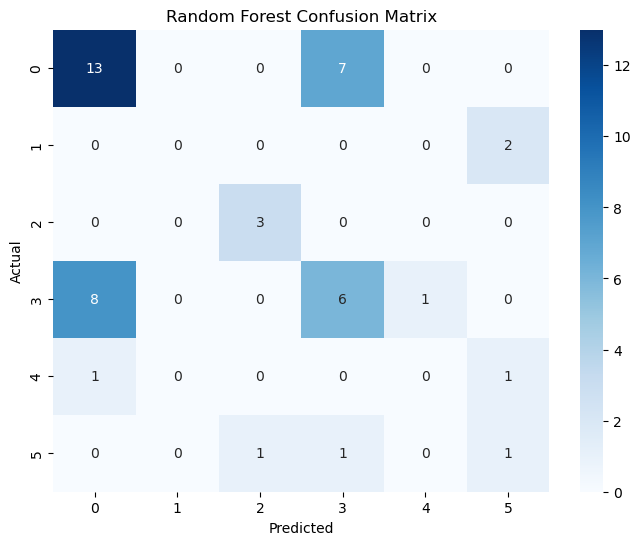

SVC Precision: 0.50
SVC Recall: 0.53
SVC F1-Score: 0.51


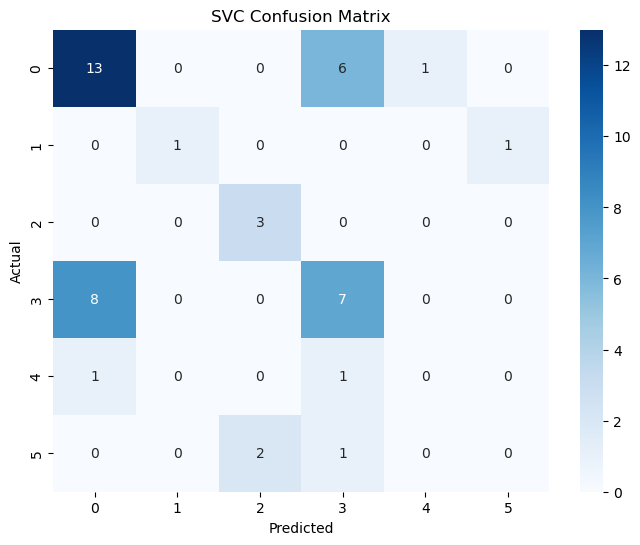

Logistic Regression Precision: 0.41
Logistic Regression Recall: 0.42
Logistic Regression F1-Score: 0.41


/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


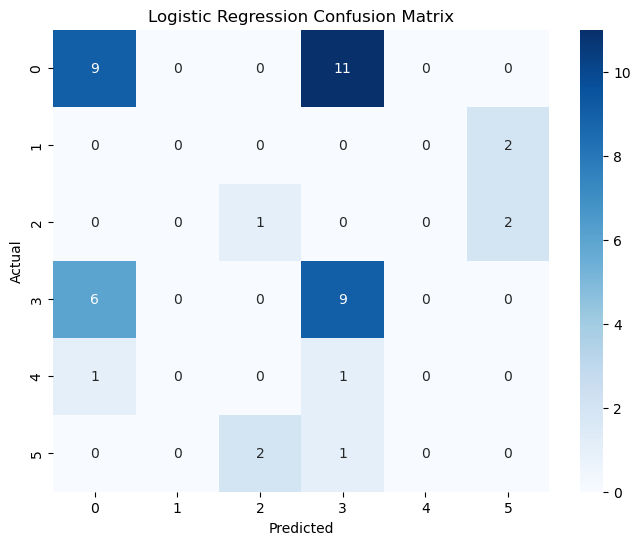

Best Model: SVC
Testing SVC on held-out test data...
SVC Precision: 0.50
SVC Recall: 0.53
SVC F1-Score: 0.51


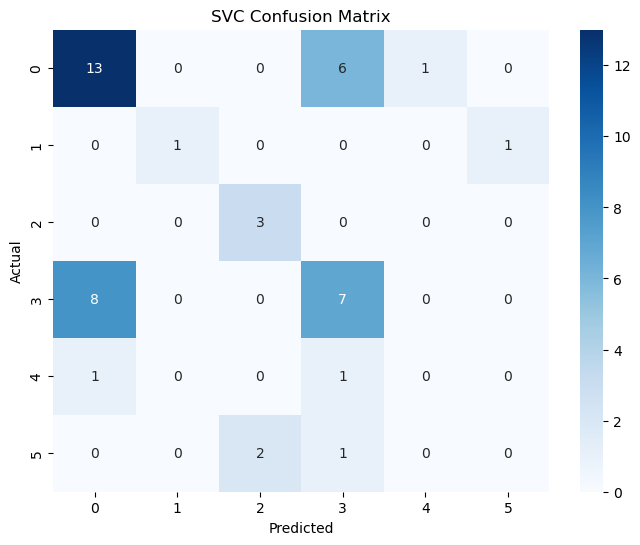

In [116]:
# Evaluate models using business-relevant metrics
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{model_name} Precision: {precision:.2f}")
    print(f"{model_name} Recall: {recall:.2f}")
    print(f"{model_name} F1-Score: {f1:.2f}")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return precision, recall, f1

# Evaluate all models
rf_metrics = evaluate_model(rf_best, X_test, y_test, "Random Forest")
svc_metrics = evaluate_model(svc_best, X_test, y_test, "SVC")
lr_metrics = evaluate_model(lr_best, X_test, y_test, "Logistic Regression")

# Select the best model based on F1-Score
model_scores = {
    "Random Forest": rf_metrics[2],
    "SVC": svc_metrics[2],
    "Logistic Regression": lr_metrics[2]
}
best_model_name = max(model_scores, key=model_scores.get)
print(f"Best Model: {best_model_name}")
best_model = {
    "Random Forest": rf_best,
    "SVC": svc_best,
    "Logistic Regression": lr_best
}[best_model_name]

# Test the chosen model on held-out test data
print(f"Testing {best_model_name} on held-out test data...")
evaluate_model(best_model, X_test, y_test, best_model_name)

# Analyze feature importance (for Random Forest)
if best_model_name == "Random Forest":
    feature_importances = best_model.feature_importances_
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances, y=X.columns)
    plt.title("Feature Importance")
    plt.show()

In [118]:
# Define directories for test data
test_images_dir = 'Test_data/Images'
test_bboxes_dir = 'Test_data/Bounding_Boxes'

# Load and preprocess test data
test_image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
test_data = []

for image_file in test_image_files:
    # Load image dimensions
    with Image.open(os.path.join(test_images_dir, image_file)) as img:
        width, height = img.size

    # Load corresponding bounding box data
    bbox_file = os.path.splitext(image_file)[0] + '.txt'
    bbox_path = os.path.join(test_bboxes_dir, bbox_file)
    if os.path.exists(bbox_path):
        with open(bbox_path, 'r') as file:
            for line in file:
                class_id, x_center, y_center, bbox_width, bbox_height = map(float, line.strip().split())
                # Scale bounding box coordinates to match the image dimensions
                x_center *= width
                y_center *= height
                bbox_width *= width
                bbox_height *= height
                test_data.append({
                    'XCenter': x_center,
                    'YCenter': y_center,
                    'Width': bbox_width,
                    'Height': bbox_height,
                    'ClassID': int(class_id)
                })

# Convert test data to DataFrame
test_df = pd.DataFrame(test_data)
X_test_data = test_df[['XCenter', 'YCenter', 'Width', 'Height']]
y_test_data = test_df['ClassID']

# Evaluate the Random Forest model on the test dataset
y_pred_test = rf_best.predict(X_test_data)
print("Random Forest Test Accuracy:", accuracy_score(y_test_data, y_pred_test))
print("Random Forest Classification Report:\n", classification_report(y_test_data, y_pred_test))

Random Forest Test Accuracy: 0.5416666666666666
Random Forest Classification Report:
               precision    recall  f1-score   support

           1       0.54      1.00      0.70        26
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1

    accuracy                           0.54        48
   macro avg       0.08      0.14      0.10        48
weighted avg       0.29      0.54      0.38        48



/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/flatiron-ai-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: 

## Business Impact Analysis

### Translating Model Metrics into Business Value
`Precision and Recall:` The Random Forest model achieved the best weighted precision and recall. This means that while the model can identify some defects accurately, it misses a significant portion of them. For a business, this translates to a moderate ability to detect defective wood, which could lead to some defective products being shipped or good products being discarded.
`F1-Score:` The F1-score of 0.49 indicates a balance between precision and recall but highlights room for improvement. This suggests that the model is not yet reliable enough for fully automated defect detection.

### Actionable Recommendations
`Improve Data Quality:` Collect more diverse and balanced data to address the issue of underrepresented classes, as seen in the classification report. This will improve the model's ability to detect rare defects.

The data was cut down a lot as well. It started with 4000 images with 4000 corresponding text files with the bounding box data inside. This was cut down to just 100 images to keep the files small enough to upload to Github. Training the model on the full dataset would help improve these scores.

`Human-in-the-Loop System:` Deploy the model as part of a semi-automated system where human inspectors review cases flagged as uncertain by the model. This will reduce the risk of missed defects while leveraging the model's strengths.

`Iterative Model Improvement:` Use feedback from production to iteratively improve the model. For example, retrain the model periodically with new data collected from real-world operations.

### Implementation Considerations and Limitations
`Class Imbalance:` The model struggles with underrepresented classes, as indicated by the low precision and recall for certain defect types. Addressing this requires techniques like oversampling, undersampling, or synthetic data generation.

`Scalability:` The Random Forest model may face challenges with scalability for very large datasets. Consider exploring more scalable algorithms like Gradient Boosting or Neural Networks if the dataset grows significantly.

`Integration with Existing Systems:` Ensure that the model integrates seamlessly with existing quality control workflows. This includes compatibility with hardware and software systems used in production.

`Cost-Benefit Analysis:` Evaluate the cost of implementing and maintaining the model against the potential savings from reduced defects and improved efficiency.